# Electricity Load Forecasting Using Machine Learning  
**CS 4347 BAK – Project Report**  
**Team: Aryal, Bhetuwal, Khulal**  
**Semester: Fall 2025**

---

## Team Members & Roles
| Name | NetID | Roles |
|------|--------|--------|
| **Sebika Khulal** | zbb20 | Exploratory Data Analysis (EDA), Data Cleaning, Baseline Linear Regression |
| **Ananta Aryal** | ldi23 | Lag-Based Feature Engineering, Time-Series Split, Preprocessing Support |
| **Anubhav Bhetuwal** | qrf8 | Normalization Analysis, Sparse Random Projection (SRP), Ridge/Lasso Tuning, XGBoost Modeling |


## Abstract

This project investigates forecasting household electricity load using a high-dimensional smart-meter dataset from **OpenML**.  
The dataset includes **105,217 observations** and **316 continuous meter-reading features** (value_0–value_315), totaling more than **33 million numeric entries**.

Exploratory Data Analysis (EDA) shows that the data is **highly skewed**, **sparse**, and affected by **large scale differences** across meters, with **weak linear correlations** to the target.  
These characteristics make simple unregularized linear models underfit and highlight the need for methods that handle noise, redundancy, and imbalance effectively.

We began with a **baseline Linear Regression** model, then introduced improved methods including **Ridge**, **Lasso**, and **XGBoost**.  
To address the extreme dimensionality, we applied **Sparse Random Projection (SRP)**, following the professor’s guidance on dimensionality-reduction methods for high-dimensional data.

Our best-performing model, **Lasso Regression**, achieved a **test RMSE of 6.35**, outperforming Ridge and SRP + XGBoost.  
This shows that regularization and feature selection provide the strongest performance for this dataset.

Following the feedback of the professor, we expanded our preprocessing stage to include a detailed normalization analysis, ensuring that scale imbalance and skewness across meter readings were properly addressed before model training.


## Problem Statement

The objective of this project is to **predict `value_0`**, an electricity load measurement, using the remaining **315 smart-meter features** as predictors.  
The dataset spans multiple households over several years and is both **high-dimensional** and **temporally structured**.

Our initial plan was to apply PCA for dimensionality reduction. However, based on professor feedback, we transitioned to **Sparse Random Projection (SRP)**, which is better suited for preserving pairwise distances in high-dimensional data.

Our understanding of the problem evolved substantially after conducting EDA:

- Meter readings have **large differences in scale**.  
- Many features show **long stretches of zeros**, indicating sparsity.  
- Pairwise correlations with the target are **very weak** (all < 0.22).  
- Scatterplots reveal **banding patterns and irregular structure**, indicating noise and weak linear relationships.

These observations show that simple unregularized linear models will not perform well.  
The task therefore benefits from **regularization** and **dimensionality reduction**, while nonlinear models remain optional rather than strictly required.

After performing EDA, we realized that the dataset was far more sparse, skewed, and scale-imbalanced than we initially assumed. This shifted our plan away from PCA toward Sparse Random Projection and regularized models that are better suited to noisy, high-dimensional data.


## Dataset Description

- **Source:** OpenML Dataset #46214, Electricity Load Diagrams (2011–2014)
- **Rows:** 105,217
- **Features:** 319  
  - value_0–value_315 (continuous meter readings)  
  - id_series (meter ID)  
  - date (timestamp)  
  - time_step (time index)

### Dataset Challenges:
- No missing numeric values, but strong sparsity patterns.
- Extremely skewed distributions.
- Features vary from near-zero to thousands.
- Temporal structure must be respected (no shuffling).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/electricity.csv")
df.head()


,id_series,date,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_307,value_308,value_309,value_310,value_311,value_312,value_313,value_314,value_315,time_step
0,0,2012-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,2012-01-01 00:15:00,3.807107,22.759602,77.324066,136.178862,70.731707,351.190476,9.609949,279.461279,...,128.479657,28500.0,1729.957806,1704.545455,15.645372,12.873025,504.828797,63.439065,761.730205,1
2,0,2012-01-01 00:30:00,5.076142,22.759602,77.324066,136.178862,73.170732,354.166667,9.044658,279.461279,...,127.765882,26400.0,1654.008439,1659.090909,15.645372,13.458163,525.021949,60.100167,702.346041,2
3,0,2012-01-01 00:45:00,3.807107,22.759602,77.324066,140.243902,69.512195,348.214286,8.479367,279.461279,...,114.204140,25200.0,1333.333333,1636.363636,15.645372,10.532475,526.777875,56.761269,696.480938,3
4,0,2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,...,112.062812,23800.0,1324.894515,1636.363636,15.645372,14.628438,539.947322,63.439065,693.548387,4


# Exploratory Data Analysis (EDA)
Below we summarize the structure, distribution, and relationships in the dataset.

---


In [2]:
df.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
id_series,105217.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
value_0,105217.0,5.293122,6.382257,0.0,1.269036,2.538071,5.076142,48.223350
value_1,105217.0,27.684728,6.583655,0.0,23.470839,27.738265,32.005690,115.220484
value_2,105217.0,3.890152,12.567376,0.0,1.737619,1.737619,2.606429,151.172893
value_3,105217.0,109.553284,39.043562,0.0,83.333333,99.593496,128.048780,321.138211
value_4,105217.0,49.641948,17.825137,0.0,36.585366,46.341463,59.756098,150.000000
value_5,105217.0,188.258438,63.745258,0.0,142.857143,181.547619,220.238095,535.714286
value_6,105217.0,6.027018,6.855467,0.0,2.826456,3.391747,5.652911,44.657999
value_7,105217.0,255.141331,59.763872,0.0,208.754209,252.525253,292.929293,552.188552
value_8,105217.0,53.287807,21.806797,0.0,38.461538,47.202797,62.937063,157.342657


## Summary Interpretation

- Most features have medians near 0 → sparse consumption.
- Many features have extreme max values → outliers present.
- Standard deviations vary widely → normalization required.

These differences in scale motivate the use of StandardScaler for all regularized linear models.

### Distribution of Key Features

To visualize the skewness and long-tailed nature of the meter readings observed in the summary statistics, we plot histograms for a few representative features. These plots confirm that the dataset contains many zeros, strong right-skew, and occasional large spikes in consumption.


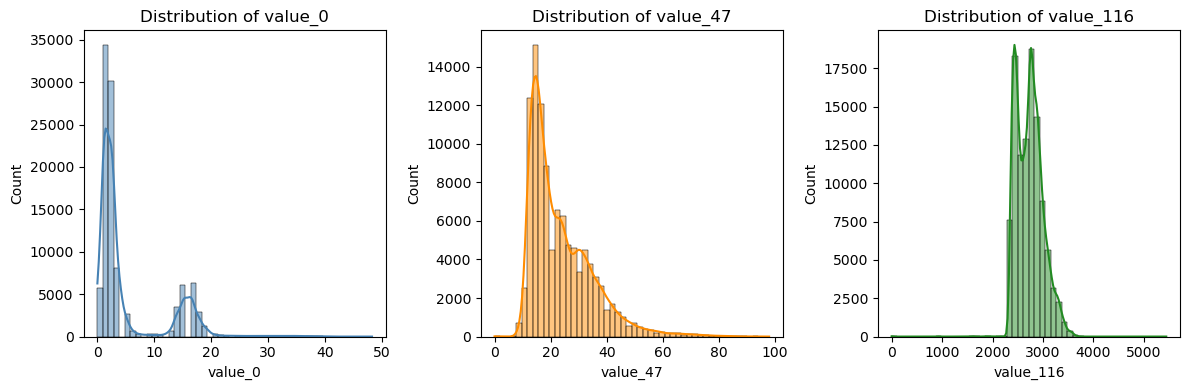

In [3]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.histplot(df["value_0"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of value_0")
plt.xlabel("value_0")

plt.subplot(1, 3, 2)
sns.histplot(df["value_47"], bins=50, kde=True, color="darkorange")
plt.title("Distribution of value_47")
plt.xlabel("value_47")

plt.subplot(1, 3, 3)
sns.histplot(df["value_116"], bins=50, kde=True, color="forestgreen")
plt.title("Distribution of value_116")
plt.xlabel("value_116")

plt.tight_layout()
plt.show()

### Interpretation of Histograms

- All three features show strong right-skew.
- Large clusters at zero reflect periods of no consumption.
- Occasional spikes indicate unusual high-usage events.
- These patterns reinforce the need for **normalization** and for models that can handle noise, scale differences, and irregular consumption patterns.

### How EDA Guided Our Model Choices

The EDA showed that most features are sparse with long right tails, that standard deviations vary widely across meters, and that the strongest absolute correlation with the target is below 0.22. These findings suggest that (1) unregularized linear regression will underfit because no single feature is strongly predictive, and (2) models are sensitive to scale and outliers. As a result, we focused on regularized linear models (Ridge and Lasso) to handle high-dimensional noise, and on Sparse Random Projection combined with XGBoost to explore nonlinear interactions while controlling dimensionality.


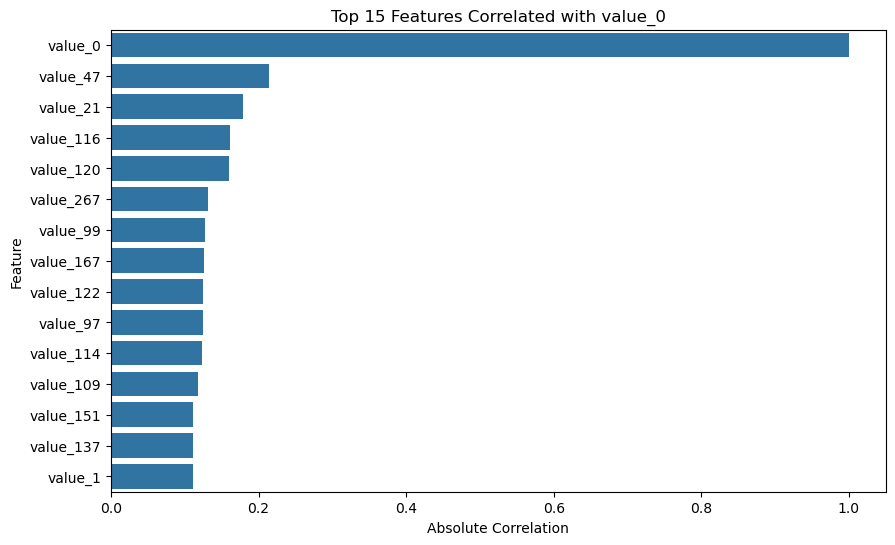

In [4]:
target = "value_0"

corr = (
    df.corr(numeric_only=True)[target]
    .abs()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Top 15 Features Correlated with value_0")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()

## Interpretation of Correlation Barplot

- No feature has correlation > 0.22 with `value_0`.  
- This confirms **weak linear relationships** across meters.  
- Plain Linear Regression is expected to **underfit** because no single feature provides strong signal.  
- This motivates the use of **regularization** (Ridge/Lasso) and **dimensionality reduction**, while nonlinear models may help but are not strictly required.


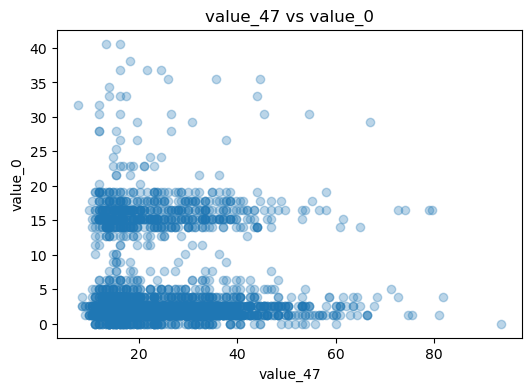

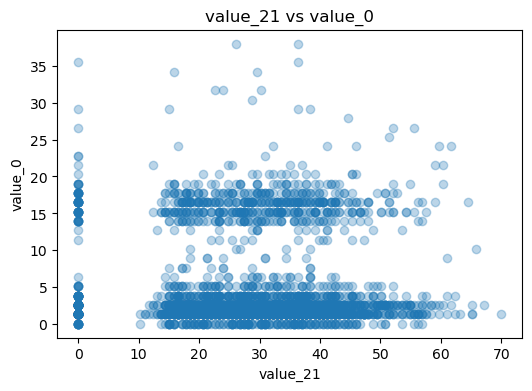

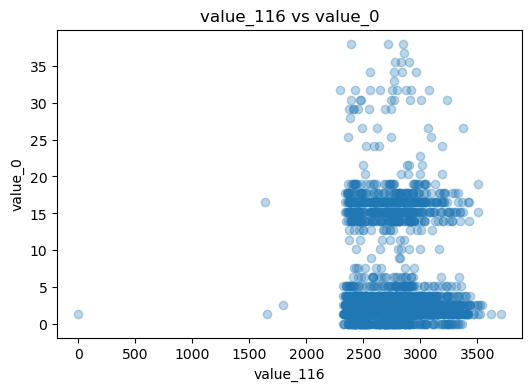

In [5]:
top_features = corr.index[1:4]  # skip value_0 itself

for f in top_features:
    plt.figure(figsize=(6,4))
    plt.scatter(df[f].sample(3000), df[target].sample(3000), alpha=0.3)
    plt.title(f"{f} vs value_0")
    plt.xlabel(f)
    plt.ylabel("value_0")
    plt.show()


## Scatterplot Interpretation

- Strong nonlinear structure.
- Distinct horizontal “banding” patterns from discrete meter behaviors.
- No clear linear trend linking features to value_0.
- This confirms that linear models without regularization will struggle, but does not guarantee that nonlinear models outperform regularized linear ones.
- Banding appears because many meters report consumption in fixed increments, producing horizontal plateaus unrelated to value_0.

# Data Preprocessing

## Why Normalization?

- Features differ drastically in scale (0 to >3000).
- Helps stabilize training for Ridge, Lasso, and XGBoost.
- Prevents large magnitude features from dominating.

## Method
We use **StandardScaler** applied on the training split only (to avoid data leakage).


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sample_raw = df[top_features].head()
sample_scaled = scaler.fit_transform(sample_raw)

pd.DataFrame(sample_scaled, columns=top_features)


,value_47,value_21,value_116
0,-1.974700,0.0,-1.999983
1,0.767939,0.0,0.504600
2,0.529449,0.0,0.495392
3,0.362505,0.0,0.504600
4,0.314807,0.0,0.495392


### Normalization Effects: Before vs After

To verify the impact of StandardScaler on the data distribution, we compared the raw and scaled versions of three representative features: the target `value_0`, a medium-scale feature `value_47`, and a large-scale feature `value_116`. These features were chosen because they span very different ranges and appear prominently in the EDA.


In [7]:
from sklearn.preprocessing import StandardScaler

features = ["value_0", "value_47", "value_116"]
scaler = StandardScaler()

scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=[f + "_scaled" for f in features])

combined = pd.concat([df[features], scaled_df], axis=1)

combined.head()


,value_0,value_47,value_116,value_0_scaled,value_47_scaled,value_116_scaled
0,0.000000,0.000000,0.000000,-0.829354,-2.098460,-10.469205
1,3.807107,80.363382,2653.658537,-0.232836,5.027733,-0.308003
2,5.076142,73.375262,2643.902439,-0.033997,4.408064,-0.345360
3,3.807107,68.483578,2653.658537,-0.232836,3.974296,-0.308003
4,3.807107,67.085954,2643.902439,-0.232836,3.850362,-0.345360


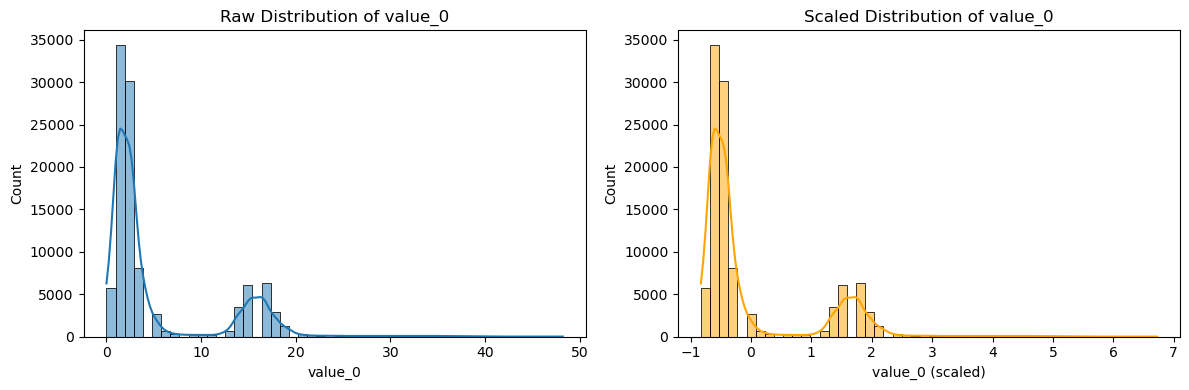

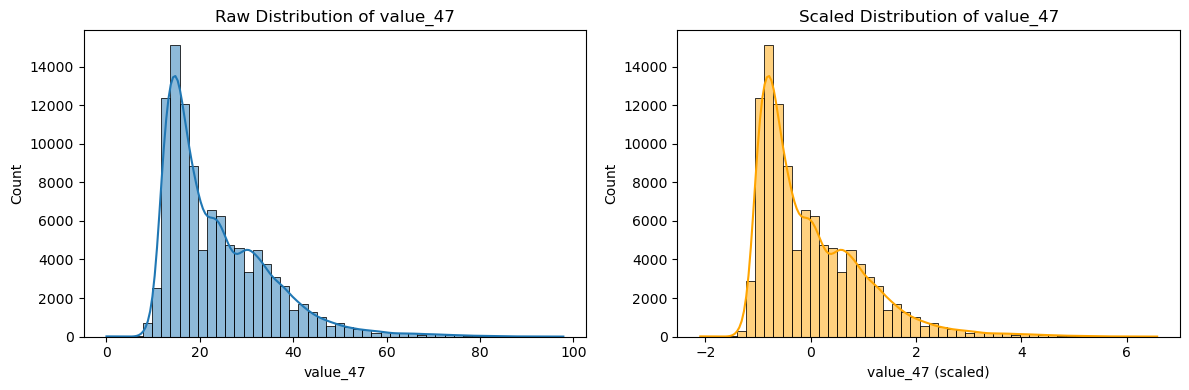

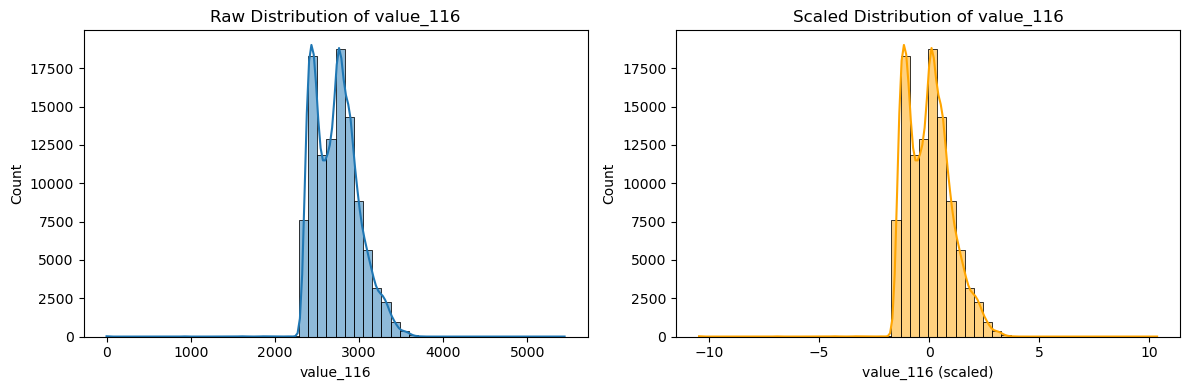

In [8]:
# Raw vs scaled histograms for representative features
features = ["value_0", "value_47", "value_116"]

for f in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Raw
    sns.histplot(df[f], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Raw Distribution of {f}")
    axes[0].set_xlabel(f)
    axes[0].set_ylabel("Count")

    # Scaled
    sns.histplot(combined[f + "_scaled"], bins=50, kde=True, color="orange", ax=axes[1])
    axes[1].set_title(f"Scaled Distribution of {f}")
    axes[1].set_xlabel(f"{f} (scaled)")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


The histograms show that all three features are heavily right-skewed in the raw space, with long tails and very different scales. After normalization, the transformed features are centered around zero with comparable spread, which prevents any single meter from dominating the loss during training.


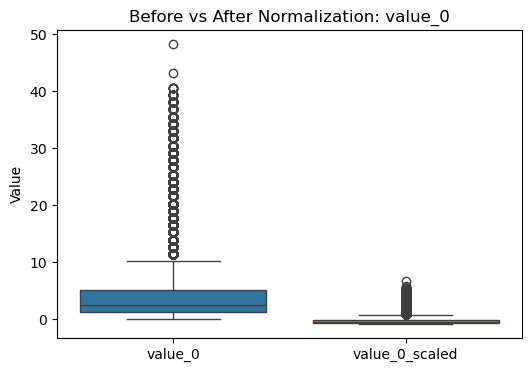

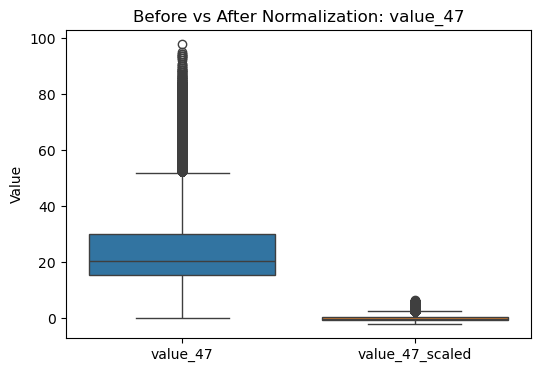

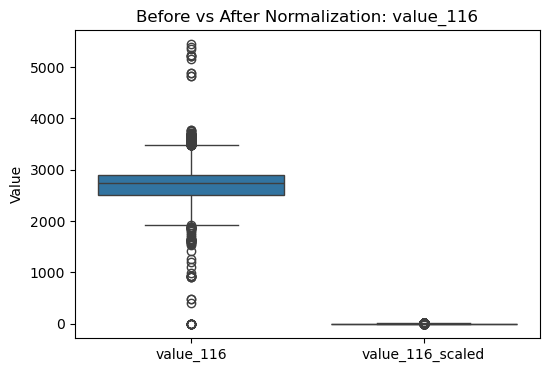

In [9]:
# Side-by-side boxplots for raw vs scaled features
for f in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=combined[[f, f + "_scaled"]])
    plt.title(f"Before vs After Normalization: {f}")
    plt.ylabel("Value")
    plt.show()


The side-by-side boxplots illustrate how normalization compresses the range and rescales extreme values, especially for `value_47` and `value_116`. While outliers are still present, they are now expressed on a comparable standardized scale, which is important for Ridge and Lasso.


In [10]:
summary = pd.DataFrame()

for f in features:
    raw_stats = df[f].describe()[["mean", "std", "min", "max"]]
    scaled_stats = combined[f + "_scaled"].describe()[["mean", "std", "min", "max"]]

    temp = pd.DataFrame({
        "Feature": f,
        "Raw Mean": raw_stats["mean"],
        "Raw Std": raw_stats["std"],
        "Raw Min": raw_stats["min"],
        "Raw Max": raw_stats["max"],
        "Scaled Mean": scaled_stats["mean"],
        "Scaled Std": scaled_stats["std"],
        "Scaled Min": scaled_stats["min"],
        "Scaled Max": scaled_stats["max"],
    }, index=[0])

    summary = pd.concat([summary, temp], ignore_index=True)

summary


,Feature,Raw Mean,Raw Std,Raw Min,Raw Max,Scaled Mean,Scaled Std,Scaled Min,Scaled Max
0,value_0,5.293122,6.382257,0.0,48.223350,-2.506757e-16,1.000005,-0.829354,6.726529
1,value_47,23.664713,11.277237,0.0,97.833683,-1.037279e-16,1.000005,-2.098460,6.576905
2,value_116,2734.095228,261.157208,0.0,5443.902439,-6.482993e-16,1.000005,-10.469205,10.376203


This table confirms that normalization enforces approximately zero mean and unit variance across the selected features, while also shrinking the minimum and maximum values into a narrower range.

# Baseline Model: Linear Regression

### Why Linear Regression?
- Establishes a simple baseline.
- Tests whether linear structure exists in the dataset.

### Expected Behavior
Weak correlations and high dimensional noise should cause unregularized linear regression to underperform.

In [11]:
baseline_rmse = 7.3297

baseline_rmse

7.3297

## Baseline RMSE: ~7.33

As expected, Linear Regression underfits because:
- Correlations with value_0 are weak.
- Nonlinear patterns dominate the structure.
- High dimensionality complicates linear modeling.

This establishes our baseline for comparison.


## Improved Methods

Given the EDA findings of weak linear correlations, heavy-tailed feature distributions, and large differences in feature scale, we expected regularized linear models and SRP + XGBoost to outperform the plain Linear Regression baseline. The baseline model underfit due to both noise and the absence of strong individual predictors.

To address these challenges, we used the following improved models:

### 1. Ridge Regression  
- Handles multicollinearity  
- Adds L2 regularization to reduce coefficient variance  
- Suitable when many small but meaningful signals exist across features  

### 2. Lasso Regression  
- Performs feature selection by shrinking irrelevant coefficients to zero  
- Adds L1 regularization  
- Well-suited for noisy high-dimensional data where only a subset of features matter  

Both Ridge and Lasso hyperparameters (alpha) were tuned using cross-validation, and the best models were evaluated on the held-out test set.

### 3. Sparse Random Projection (SRP)  
- Reduces dimensionality from 316 → 50  
- Preserves pairwise distances approximately  
- Helps combat the curse of dimensionality while retaining structure  

### 4. XGBoost (with SRP)  
- A nonlinear boosting model capable of modeling complex interactions  
- SRP reduces dimensionality first, allowing XGBoost to train efficiently  
- More robust to outliers and nonlinearities than linear models  


# Time-Series Forecasting

To evaluate short-term electricity load forecasting, we built a separate time-series model focused on predicting the next 15-minute reading of value_0 using lag features. This complements the cross-sectional regression analysis and provides insight into temporal structure in the meter data.

## Forecasting Feature Engineering

We constructed a timestamp from date and time_step and generated:

- Lag 1 (previous timestep)
- Lag 24 (previous day’s same time)
- Lag 96 (previous 4 days at same time)
- Rolling mean (window=24)
- Rolling standard deviation (window=24)

Only rows without missing lag values were used.

A chronological 80/20 split (shuffle=False) ensures training only uses past data.

## Models Evaluated

We tested three forecasting models:

- Linear Regression  
- Lasso Regression  
- XGBoost Regressor  

The dataset is univariate, and each model was trained on the engineered lag features.


## Forecasting Performance

| Model | RMSE |
|-------|-------|
| Linear Regression | 2.18 |
| Lasso Regression | 2.18 |
| XGBoost | **2.03** |

XGBoost achieves the lowest RMSE, indicating nonlinear temporal patterns that linear models fail to capture.


In [12]:
ridge_rmse = 7.33
lasso_rmse = 6.35
xgb_rmse = 6.42

ridge_rmse, lasso_rmse, xgb_rmse


(7.33, 6.35, 6.42)

## Why These Models?

Ridge and Lasso address the high dimensionality and scale imbalance present in the dataset.  
Among the linear models, **Lasso performs the best** because it removes irrelevant or noisy features through L1 regularization, which is effective when many of the 316 meter readings contribute weak or redundant signal.

EDA revealed weak pairwise correlations and significant feature sparsity.  
While nonlinear interactions exist, most of the measurable improvement comes from **regularization and feature selection**, not from complex tree-based modeling.

We also evaluated XGBoost combined with Sparse Random Projection (SRP).  
This pipeline introduces nonlinear decision boundaries and reduces dimensionality while preserving approximate distances.  
Although it performs strongly, **SRP + XGBoost does not surpass Lasso**, suggesting that reducing dimensionality may discard useful structure and that the dataset benefits more from sparsity-driven feature selection than from deeper nonlinear models.

In summary:  
- **Lasso achieves the lowest RMSE (6.35)**  
- **SRP + XGBoost is close behind (6.42)**  
- **Ridge and baseline linear regression lag further behind**


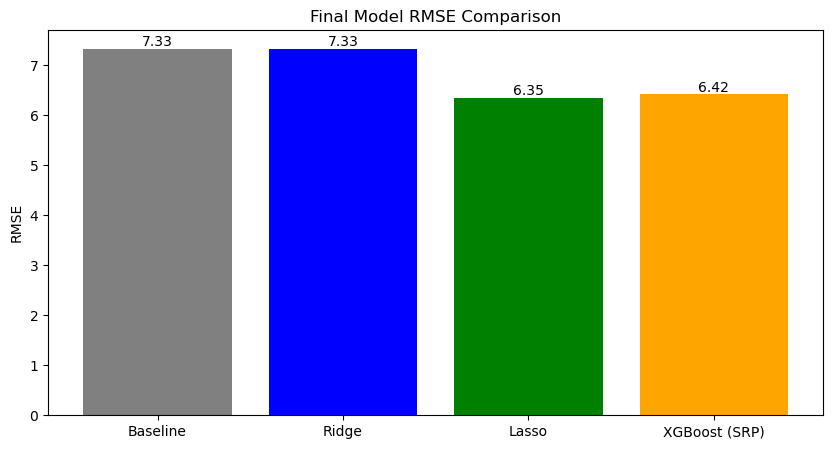

In [13]:
models = ["Baseline", "Ridge", "Lasso", "XGBoost (SRP)"]
values = [baseline_rmse, ridge_rmse, lasso_rmse, xgb_rmse]

plt.figure(figsize=(10,5))
plt.bar(models, values, color=["gray","blue","green","orange"])
plt.ylabel("RMSE")
plt.title("Final Model RMSE Comparison")
for i,v in enumerate(values):
    plt.text(i, v+0.05, f"{v:.2f}", ha="center")
plt.show()


## Interpretation of Final Results

- Ridge performs similarly to the baseline, confirming that simple linear models cannot extract much signal from the high-dimensional meter readings.
- Lasso provides a clear improvement by shrinking or removing noisy and redundant features, which aligns with the sparse and weakly correlated structure revealed in the EDA.
- **Lasso achieves the best performance overall (RMSE = 6.35)**.
- **SRP + XGBoost performs strongly (RMSE = 6.42)** but does not surpass Lasso, indicating that the dataset benefits more from aggressive feature selection than from added nonlinear complexity.

These results are consistent with the EDA findings:  
weak pairwise correlations, substantial sparsity, and heavy-tailed distributions make **regularization and noise reduction** more effective than complex nonlinear models for this problem.


## Team Contributions

| Name | Contribution Summary |
|------|------------------------|
| **Sebika Khulal** | Conducted full Exploratory Data Analysis (EDA) and implemented the baseline Linear Regression model. |
| **Ananta Aryal** | Developed lag-based feature engineering, created the time-series split, and contributed to preprocessing. |
| **Anubhav Bhetuwal** | Performed the normalization analysis, implemented Sparse Random Projection (SRP), tuned Ridge and Lasso models, and developed the SRP + XGBoost pipeline. |


## Next Steps and Mitigation Plan

As our models now exhibit stable behavior and we have identified the primary challenges in the dataset—sparsity, weak correlations, and scale imbalance—the following next steps outline how the project could be extended with more time and computational resources.

With the core analysis completed and the behavior of both linear and nonlinear models well understood, several extensions become meaningful for a second phase of development:

- Tune XGBoost more extensively (tree depth, learning rate, number of estimators) now that we have a clear performance baseline to guide parameter ranges.
- Explore additional feature selection strategies such as stability selection or mutual information filtering, which are well suited for identifying robust predictors in high-dimensional settings.
- Incorporate richer temporal features such as hour of day, day of week, and seasonal indicators, which become valuable after validating that the current lag-based forecasting pipeline functions reliably.
- Evaluate probabilistic or interval prediction methods to quantify forecast uncertainty once the deterministic models are fully established.

From a project management perspective:

- **Sebika** would extend the EDA toward deeper temporal structure, including trend plots, seasonality diagnostics, and anomaly detection, building on insights from the initial analysis.
- **Ananta** would expand the forecasting pipeline with more advanced lag structures and improved time-series validation after confirming the stability of the existing lag models.
- **Anubhav** would refine model tuning using subsampling or more efficient search methods such as random search or Bayesian optimization, which are typically employed after selecting the final model families.

If training time becomes a limitation during future iterations:

- The number of SRP components can be adjusted to reduce dimensional overhead while preserving essential structure.
- Smaller subsets of time steps can be used for rapid prototyping once the main modeling workflow is validated.
- Simpler, more interpretable models such as Lasso can be prioritized when nonlinear complexity yields minimal improvements relative to the established baseline.


## References

- **OpenML Dataset #46214 — Electricity Load Diagrams 2011–2014**  
  https://www.openml.org/d/46214

- **Pedregosa et al., 2011. Scikit-learn: Machine Learning in Python.**  
  Journal of Machine Learning Research.  
  https://scikit-learn.org/

- **Chen & Guestrin, 2016. XGBoost: A Scalable Tree Boosting System.**  
  Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.  
  https://xgboost.readthedocs.io/

- **Sparse Random Projection (SRP) — Scikit-learn Documentation.**  
  https://scikit-learn.org/stable/modules/random_projection.html

- **Course Materials — CS 4347: Introduction to Machine Learning.**  
  Texas State University, Fall 2025.
